In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
import glob
import scipy.stats as stats


sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 100})
sns.set_style("ticks")

# AD Classifier

Strategy - only start with activator TFs. Assuming that only these TFs have been correctly annotated with an AD.

Need:
1. Sequences
2. Disorder
3. Protein alignment percent identities
4. CDS PhyloP scores
5. MTR
6. Overlaps AD annotation?

# 1. Getting sequences

In [4]:
lambert_TFs = pd.read_csv("../output/lambert_TFs_10-21-24_with_DBD_coords.csv", index_col = 0)
protfasta.write_fasta(dict(zip(lambert_TFs["id"], lambert_TFs["ProteinSeq"])), "../output/lambert_TFs_10-21-24_with_DBD_coords.fasta")
lambert_TFs

,id,ProteinSeq,DBD_coords_merged
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243], [249, 271], [277, 299], [305, 327..."
1,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,"[[114, 182], [262, 347]]"
2,sp|A0PJY2|FEZF1_HUMAN Fez family zinc finger p...,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,"[[260, 282], [288, 310], [316, 338], [344, 366..."
3,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,"[[1, 330]]"
4,sp|A1YPR0|ZBT7C_HUMAN Zinc finger and BTB doma...,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,"[[364, 386], [392, 414], [420, 442], [448, 469]]"
...,...,...,...
1608,sp|Q9Y6Q9|NCOA3_HUMAN Nuclear receptor coactiv...,MSGLGENLDPLASDSRKRKLPCDTPGQGLTCSGEKRRREQESKYIE...,"[[31, 83]]"
1609,sp|Q9Y6R6|Z780B_HUMAN Zinc finger protein 780B...,MVHGSVTFRDVAIDFSQEEWECLQPDQRTLYRDVMLENYSHLISLG...,"[[165, 187], [193, 215], [221, 243], [249, 271..."
1610,sp|Q9Y6X0|SETBP_HUMAN SET-binding protein OS=H...,MESRETLSSSRQRGGESDFLPVSSAKPPAAPGCAGEPLLSTPGPGK...,"[[583, 596], [1015, 1027], [1450, 1462]]"
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[[78, 101], [110, 133], [271, 317], [442, 496]..."


In [5]:
# Tiling lambert 
tiled_lambert = AD_predictor_tools.makeTilingDF("../output/lambert_TFs_10-21-24_with_DBD_coords.fasta", window_size = 40, window_spacing = 40)
tiled_lambert

Using existing Tiling DF at ../data/TilingDFs/lambert_TFs_10-21-24_with_DBD_coords_size_40_space_40_AAs_W,F,Y,M,L,Q.csv


,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,2,0,2,7,-7
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,3,7,0,4,6
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,6,3,0,1,8
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,7,6,1,0,12


### 2. Adding disorder

In [6]:
# slow to run
percent_disorders = []
for i in tiled_lambert.index:
    percent_disorders.append(meta.percent_disorder(tiled_lambert["ProteinWindowSeq"].iloc[i]))
    if i%10000 == 0:
        print(i)
        
tiled_lambert["percent_disorder"] = percent_disorders

0
10000
20000


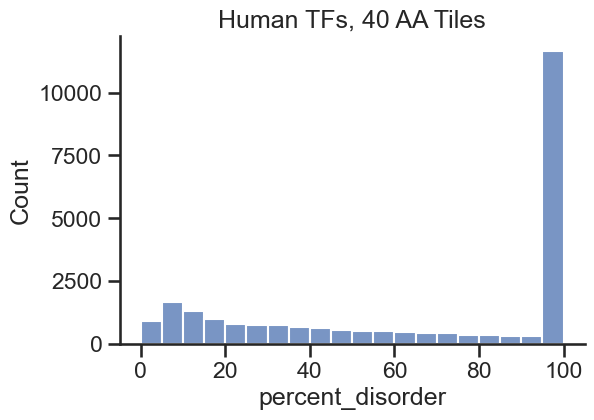

In [7]:
sns.set_context('talk')
sns.histplot(tiled_lambert["percent_disorder"], bins = 20)
plt.title("Human TFs, 40 AA Tiles")
sns.despine()

# 3. Adding percent identities from protein alignment

In [8]:
tiled_lambert["uniprotID"] = tiled_lambert["GeneName"].str.split("|").str[1]
tiled_lambert

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6,97.5,A0A087WUV0
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1,65.0,A0A087WUV0
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8,85.0,A0A087WUV0
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6,100.0,A0A087WUV0
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2,100.0,A0A087WUV0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,2,0,2,7,-7,80.0,Q9Y6Y1
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,3,7,0,4,6,0.0,Q9Y6Y1
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,6,3,0,1,8,2.5,Q9Y6Y1
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,7,6,1,0,12,67.5,Q9Y6Y1


In [9]:
gene_name_mappings = pd.read_csv("../data/TF_uniprotIDs_to_gene_names.tsv", sep = "\t")
gene_name_mappings = gene_name_mappings.rename(columns = {"From" : "uniprotID", "Gene Names" : "gene"})
gene_name_mappings["gene"] = gene_name_mappings["gene"].str.split(" ").str[0]
gene_name_mappings = gene_name_mappings.drop(columns = "Entry")
gene_name_mappings

,uniprotID,gene
0,A0A087WUV0,ZNF892
1,A0AVK6,E2F8
2,A0PJY2,FEZF1
3,A1A519,FAM170A
4,A1YPR0,ZBTB7C
...,...,...
1585,Q9Y6Q9,NCOA3
1586,Q9Y6R6,ZNF780B
1587,Q9Y6X0,SETBP1
1588,Q9Y6X8,ZHX2


In [52]:
tiled_lambert_with_gene = pd.merge(tiled_lambert, gene_name_mappings, how = "left")
tiled_lambert_with_gene

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID,gene
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6,97.5,A0A087WUV0,ZNF892
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1,65.0,A0A087WUV0,ZNF892
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8,85.0,A0A087WUV0,ZNF892
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6,100.0,A0A087WUV0,ZNF892
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2,100.0,A0A087WUV0,ZNF892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,2,0,2,7,-7,80.0,Q9Y6Y1,CAMTA1
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,3,7,0,4,6,0.0,Q9Y6Y1,CAMTA1
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,6,3,0,1,8,2.5,Q9Y6Y1,CAMTA1
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,7,6,1,0,12,67.5,Q9Y6Y1,CAMTA1


In [11]:
# Prepare percent identities for merge
tile_percent_identities = []

for path in glob.glob("../data/zoonomia_toga_mca/prot_alignment_percent_identities_for_vis/*"):
    gene_df = pd.read_csv(path, index_col = 0)
    starts, ends, percent_identity_lists, avg_percent_identity = [], [], [], []
    for i in np.arange(len(gene_df) - 40 + 1):
        percent_identity_lists.append(list(gene_df["percent_identity"][i : i + 40]))
        avg_percent_identity.append(np.mean(list(gene_df["percent_identity"][i : i + 40])))
        starts.append(i)
        ends.append(i + 40)
    
    tile_percent_identities.append(pd.DataFrame({"gene" : path, 
                  "StartPosition" : starts, 
                  "EndPosition" : ends, 
                  "percent_identity" : percent_identity_lists,
                "avg_percent_identity" : avg_percent_identity}))

tile_percent_identities = pd.concat(tile_percent_identities)
tile_percent_identities["gene"] = tile_percent_identities["gene"].str.split("/").str[-1]
tile_percent_identities

,gene,StartPosition,EndPosition,percent_identity,avg_percent_identity
0,TBX4,0,40,"[83.99168399168398, 84.82328482328482, 86.6943...",76.096674
1,TBX4,1,41,"[84.82328482328482, 86.6943866943867, 88.56548...",75.415800
2,TBX4,2,42,"[86.6943866943867, 88.56548856548856, 84.61538...",73.581081
3,TBX4,3,43,"[88.56548856548856, 84.61538461538461, 88.3575...",73.316008
4,TBX4,4,44,"[84.61538461538461, 88.35758835758836, 82.9521...",73.092516
...,...,...,...,...,...
199,JAZF1,199,239,"[98.54469854469856, 98.75259875259876, 98.7525...",98.180873
200,JAZF1,200,240,"[98.75259875259876, 98.75259875259876, 98.7525...",98.186071
201,JAZF1,201,241,"[98.75259875259876, 98.75259875259876, 98.7525...",98.180873
202,JAZF1,202,242,"[98.75259875259876, 98.75259875259876, 98.5446...",98.180873


In [53]:
tiled_lambert_with_gene = pd.merge(tiled_lambert_with_gene, tile_percent_identities, on = ["gene", "StartPosition", "EndPosition"], how = "left")
tiled_lambert_with_gene

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6,97.5,A0A087WUV0,ZNF892,NaN,NaN
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1,65.0,A0A087WUV0,ZNF892,NaN,NaN
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8,85.0,A0A087WUV0,ZNF892,NaN,NaN
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6,100.0,A0A087WUV0,ZNF892,NaN,NaN
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2,100.0,A0A087WUV0,ZNF892,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,2,0,2,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,3,7,0,4,6,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,6,3,0,1,8,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,7,6,1,0,12,67.5,Q9Y6Y1,CAMTA1,"[98.2532751091703, 87.77292576419214, 56.55021...",95.447598


In [54]:
tiled_lambert_with_gene[tiled_lambert_with_gene["ProteinWindowSeq"].isna()]

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity


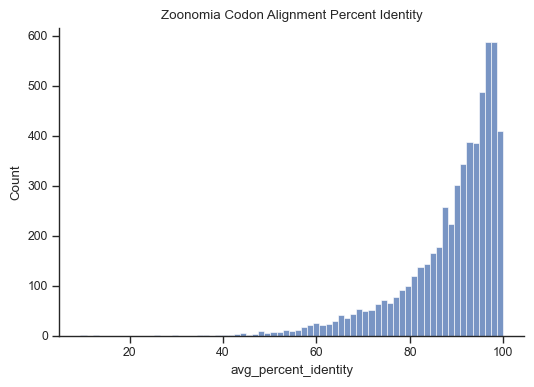

In [55]:
sns.histplot(tiled_lambert_with_gene["avg_percent_identity"])
sns.despine()
plt.title("Zoonomia Codon Alignment Percent Identity");

In [56]:
tiled_lambert_with_gene

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6,97.5,A0A087WUV0,ZNF892,NaN,NaN
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1,65.0,A0A087WUV0,ZNF892,NaN,NaN
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8,85.0,A0A087WUV0,ZNF892,NaN,NaN
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6,100.0,A0A087WUV0,ZNF892,NaN,NaN
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2,100.0,A0A087WUV0,ZNF892,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,2,0,2,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,3,7,0,4,6,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,6,3,0,1,8,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,7,6,1,0,12,67.5,Q9Y6Y1,CAMTA1,"[98.2532751091703, 87.77292576419214, 56.55021...",95.447598


In [47]:
# x = tiled_lambert_with_gene["percent_disorder"]
# y = tiled_lambert_with_gene["avg_percent_identity"]
# correlation_coefficient, p_value = stats.pearsonr(x, y)
# correlation_coefficient

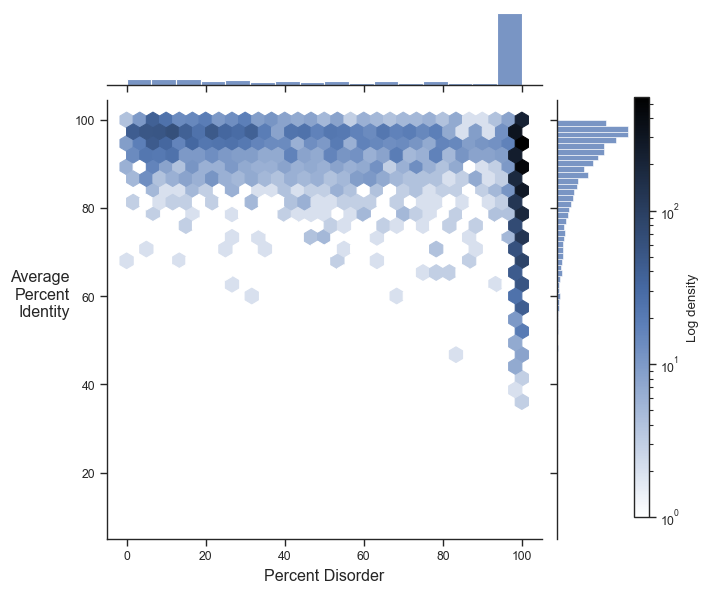

In [48]:
sns.set_context('paper')
g = sns.jointplot(data = tiled_lambert_with_gene, x = "percent_disorder", y = "avg_percent_identity", kind = "hex", bins = "log", gridsize = 30)
plt.xlabel("Percent Disorder", fontsize = "large")
plt.ylabel("Average\nPercent\nIdentity", fontsize = "large", rotation = 0, ha = "right")
cax = g.fig.add_axes([.98, 0.13, 0.025, 0.7])
plt.colorbar(cax=cax, label = "Log density")
#print(correlation_coefficient);

# 4. CDS PhyloP Scores

In [18]:
cds_phylo_P = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_zoonomia_all_TF_cds/*")
for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]
    df = pd.read_csv(path, sep = "\t", header = None)
    cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {3: "ENST", 8: "PhyloP"})
cds_phylo_P

,0,1,2,ENST,4,5,6,7,PhyloP
0,2,27149134,27149135,ENST00000296096,1,2,27149134,27149135,4.624
1,2,27149135,27149136,ENST00000296096,1,2,27149135,27149136,6.891
2,2,27149136,27149137,ENST00000296096,1,2,27149136,27149137,1.666
3,2,27149137,27149138,ENST00000296096,1,2,27149137,27149138,5.833
4,2,27149138,27149139,ENST00000296096,1,2,27149138,27149139,-0.157
...,...,...,...,...,...,...,...,...,...
3850,16,49822681,49822682,ENST00000561648,-1,16,49822681,49822682,0.452
3851,16,49822682,49822683,ENST00000561648,-1,16,49822682,49822683,-0.104
3852,16,49822683,49822684,ENST00000561648,-1,16,49822683,49822684,-0.824
3853,16,49822684,49822685,ENST00000561648,-1,16,49822684,49822685,0.588


In [19]:
def get_phylop_scores(ENST):
    #ENST = cc_names[cc_names["Gene"] == gene]["ENST"].iloc[0]
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    
    if ENST_phylo_P[4].iloc[0] == -1:
        ascending = False
    else: 
        #print("pos")
        ascending = True
        
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    ENST_phylo_P["cds_nt"] = np.arange(len(ENST_phylo_P)) / 3
    ENST_phylo_P = ENST_phylo_P.reset_index(drop = True)

    return ENST_phylo_P


In [20]:
tile_phylops = []

for ENST in set(cds_phylo_P["ENST"]):
    ENST_phylo_P = get_phylop_scores(ENST)
    
    starts, ends, phylop_lists, avg_phylop = [], [], [], []
    
    for i in np.arange(len(ENST_phylo_P) - 120 + 1):
        phylop_lists.append(list(ENST_phylo_P["PhyloP"][i : i + 120]))
        avg_phylop.append(np.mean(list(ENST_phylo_P["PhyloP"][i : i + 120])))
        starts.append(i)
        ends.append(i + 120)
    
    tile_phylops.append(pd.DataFrame({"ENST" : ENST, 
                  "StartPosition" : starts, 
                  "EndPosition" : ends, 
                  "PhyloP" : phylop_lists,
                "average_PhyloP" : avg_phylop}))

tile_phylops = pd.concat(tile_phylops)
tile_phylops

,ENST,StartPosition,EndPosition,PhyloP,average_PhyloP
0,ENST00000262525,0,120,"[2.025, 6.307, 4.644, 8.827, 8.827, 6.307, 4.0...",3.363967
1,ENST00000262525,1,121,"[6.307, 4.644, 8.827, 8.827, 6.307, 4.006, 8.7...",3.365442
2,ENST00000262525,2,122,"[4.644, 8.827, 8.827, 6.307, 4.006, 8.721, 8.7...",3.371100
3,ENST00000262525,3,123,"[8.827, 8.827, 6.307, 4.006, 8.721, 8.721, -3....",3.380158
4,ENST00000262525,4,124,"[8.827, 6.307, 4.006, 8.721, 8.721, -3.105, 8....",3.334900
...,...,...,...,...,...
1157,ENST00000440367,1157,1277,"[3.333, 5.908, -0.167, 2.816, 0.293, 0.632, 0....",1.403483
1158,ENST00000440367,1158,1278,"[5.908, -0.167, 2.816, 0.293, 0.632, 0.109, 0....",1.380250
1159,ENST00000440367,1159,1279,"[-0.167, 2.816, 0.293, 0.632, 0.109, 0.946, 0....",1.347017
1160,ENST00000440367,1160,1280,"[2.816, 0.293, 0.632, 0.109, 0.946, 0.652, 2.8...",1.357108


In [21]:
all_TFs_table = pd.read_csv("../soto_analysis/outputs/all_TFs_table_proteins.txt", sep = "\t")
ENST_mapping = all_TFs_table[["ENST", "uniprotID"]]
ENST_mapping

,ENST,uniprotID
0,ENST00000334384,A6NJG6
1,ENST00000428390,A8MTJ6
2,ENST00000641094,A8MYZ6
3,ENST00000640845,A8MZ59
4,ENST00000403402,O00321
...,...,...
441,ENST00000382276,Q9Y5R6
442,ENST00000248071,Q9Y5W3
443,ENST00000294409,Q9Y692
444,ENST00000371998,Q9Y6Q9


In [22]:
# tiled_lambert_with_gene.to_csv("../data/tiled_lambert_with_gene_disorder_perc_ident.csv")

In [49]:
# tiled_lambert_with_gene = pd.read_csv("../data/tiled_lambert_with_gene_disorder_perc_ident.csv", index_col = 0)
# tiled_lambert_with_gene

In [58]:
tiled_lambert_with_gene

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6,97.5,A0A087WUV0,ZNF892,NaN,NaN
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1,65.0,A0A087WUV0,ZNF892,NaN,NaN
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8,85.0,A0A087WUV0,ZNF892,NaN,NaN
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6,100.0,A0A087WUV0,ZNF892,NaN,NaN
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2,100.0,A0A087WUV0,ZNF892,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,2,0,2,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943
24536,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,3,7,0,4,6,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563
24537,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,6,3,0,1,8,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476
24538,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,7,6,1,0,12,67.5,Q9Y6Y1,CAMTA1,"[98.2532751091703, 87.77292576419214, 56.55021...",95.447598


In [59]:
ENST_mapping

,ENST,uniprotID
0,ENST00000334384,A6NJG6
1,ENST00000428390,A8MTJ6
2,ENST00000641094,A8MYZ6
3,ENST00000640845,A8MZ59
4,ENST00000403402,O00321
...,...,...
441,ENST00000382276,Q9Y5R6
442,ENST00000248071,Q9Y5W3
443,ENST00000294409,Q9Y692
444,ENST00000371998,Q9Y6Q9


In [61]:
tiled_lambert_with_gene[~tiled_lambert_with_gene["uniprotID"].isin(ENST_mapping["uniprotID"])]

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,K,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,40,0,1,0,2,6,1,1,1,3,5,-6,97.5,A0A087WUV0,ZNF892,NaN,NaN
1,RDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVI,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,40,80,1,0,0,1,6,3,1,3,3,2,-1,65.0,A0A087WUV0,ZNF892,NaN,NaN
2,SQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEE,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,80,120,1,0,0,0,3,2,4,1,1,12,-8,85.0,A0A087WUV0,ZNF892,NaN,NaN
3,ESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,120,160,0,1,0,0,3,3,2,1,1,8,-6,100.0,A0A087WUV0,ZNF892,NaN,NaN
4,EKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKN,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,160,200,0,2,1,0,3,5,2,6,2,4,2,100.0,A0A087WUV0,ZNF892,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24493,HLLRSTFARTQWPTPQEYDQLAAKTGLVRTEIVRWFKENR,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,640,680,2,2,1,0,4,3,2,5,1,3,3,30.0,Q9Y6X8,ZHX2,NaN,NaN
24494,CLLKTGTVKWMEQYQHQPMADDHGYDAVARKATKPMAESP,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,680,720,1,0,2,3,2,3,4,1,3,2,0,85.0,Q9Y6X8,ZHX2,NaN,NaN
24495,KNGGDVVPQYYKDPKKLCEEDLEKLVTRVKVGSEPAKDCL,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,720,760,0,0,2,0,4,1,7,1,4,4,0,42.5,Q9Y6X8,ZHX2,NaN,NaN
24496,PAKPSEATSDRSEGSSRDGQGSDENEESSVVDYVEVTVGE,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,760,800,0,0,1,0,0,1,1,2,4,7,-8,100.0,Q9Y6X8,ZHX2,NaN,NaN


In [62]:
pd.merge(tiled_lambert_with_gene, ENST_mapping)

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity,ENST
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,3,2,1,1,100.0,A6NJG6,ARGFX,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,4,1,1,4,100.0,A6NJG6,ARGFX,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,3,2,6,-4,12.5,A6NJG6,ARGFX,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,5,0,0,12,72.5,A6NJG6,ARGFX,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,0,2,1,-3,100.0,A6NJG6,ARGFX,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6611,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,0,2,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635
6612,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,7,0,4,6,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635
6613,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,3,0,1,8,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635
6614,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,...,6,1,0,12,67.5,Q9Y6Y1,CAMTA1,"[98.2532751091703, 87.77292576419214, 56.55021...",95.447598,ENST00000303635


In [63]:
tiled_lambert_with_gene = pd.merge(tiled_lambert_with_gene, ENST_mapping)
tiled_lambert_with_gene

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,R,D,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity,ENST
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,3,2,1,1,100.0,A6NJG6,ARGFX,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,4,1,1,4,100.0,A6NJG6,ARGFX,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,3,2,6,-4,12.5,A6NJG6,ARGFX,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,5,0,0,12,72.5,A6NJG6,ARGFX,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,0,2,1,-3,100.0,A6NJG6,ARGFX,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6611,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,0,2,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635
6612,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,7,0,4,6,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635
6613,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,3,0,1,8,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635
6614,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1600,1640,0,0,3,0,3,6,...,6,1,0,12,67.5,Q9Y6Y1,CAMTA1,"[98.2532751091703, 87.77292576419214, 56.55021...",95.447598,ENST00000303635


In [25]:
tile_phylops["EndPosition"] = tile_phylops["EndPosition"] - 80
tile_phylops

,ENST,StartPosition,EndPosition,PhyloP,average_PhyloP
0,ENST00000262525,0,40,"[2.025, 6.307, 4.644, 8.827, 8.827, 6.307, 4.0...",3.363967
1,ENST00000262525,1,41,"[6.307, 4.644, 8.827, 8.827, 6.307, 4.006, 8.7...",3.365442
2,ENST00000262525,2,42,"[4.644, 8.827, 8.827, 6.307, 4.006, 8.721, 8.7...",3.371100
3,ENST00000262525,3,43,"[8.827, 8.827, 6.307, 4.006, 8.721, 8.721, -3....",3.380158
4,ENST00000262525,4,44,"[8.827, 6.307, 4.006, 8.721, 8.721, -3.105, 8....",3.334900
...,...,...,...,...,...
1157,ENST00000440367,1157,1197,"[3.333, 5.908, -0.167, 2.816, 0.293, 0.632, 0....",1.403483
1158,ENST00000440367,1158,1198,"[5.908, -0.167, 2.816, 0.293, 0.632, 0.109, 0....",1.380250
1159,ENST00000440367,1159,1199,"[-0.167, 2.816, 0.293, 0.632, 0.109, 0.946, 0....",1.347017
1160,ENST00000440367,1160,1200,"[2.816, 0.293, 0.632, 0.109, 0.946, 0.652, 2.8...",1.357108


In [64]:
# Lose 7,000 of 219000 rows
tiled_lambert_with_phylop = pd.merge(tiled_lambert_with_gene, tile_phylops)
tiled_lambert_with_phylop

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,1,1,100.0,A6NJG6,ARGFX,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384,"[-4.108, -0.452, 0.105, -0.257, 0.559, -0.061,...",0.029225
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,1,4,100.0,A6NJG6,ARGFX,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384,"[2.4, 0.686, -0.809, 0.699, 0.223, 0.643, 0.73...",-0.050108
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,6,-4,12.5,A6NJG6,ARGFX,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384,"[0.315, 2.006, 0.604, 2.033, 1.516, -0.445, -0...",-0.083100
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,0,12,72.5,A6NJG6,ARGFX,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384,"[-0.6, -0.014, 0.807, -0.171, -0.605, 0.8, 0.4...",-0.170567
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,1,-3,100.0,A6NJG6,ARGFX,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384,"[-0.019, -0.757, -0.129, -0.074, -0.018, 0.625...",0.087592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,0,0,2,0,4,1,...,1,-2,100.0,Q9Y6Y1,CAMTA1,"[98.68995633187772, 66.15720524017468, 98.6899...",89.743450,ENST00000303635,"[6.337, 8.763, 6.311, 6.311, 7.101, 6.337, 6.3...",4.736008
5977,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792
5978,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,4,6,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635,"[8.763, 0.745, -0.218, -0.687, 1.504, 2.653, -...",4.331908
5979,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,1,8,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635,"[0.502, 2.957, 6.331, 4.674, 1.191, -0.333, 8....",4.150142


In [65]:
tiled_lambert_with_phylop[(tiled_lambert_with_phylop["percent_disorder"] % 10 == 0) & (tiled_lambert_with_phylop["percent_disorder"] != 100)]

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,E,Charge,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP
35,IQLWQFLLELLHDGARSSCIRWTGNSREFQLCDPKEVARL,sp|O00321|ETV2_HUMAN ETS translocation variant...,240,280,2,2,0,0,7,3,...,3,0,50.0,O00321,ETV2,"[89.66861598440546, 91.03313840155946, 91.2280...",87.236842,ENST00000403402,"[0.742, 0.345, -0.086, 2.235, 0.65, 6.791, 0.4...",1.010383
44,TIHSTGYLKSWPPTKMGLDEDNEPDNEGCNLSCLVAIGRL,sp|O00327|BMAL1_HUMAN Basic helix-loop-helix A...,280,320,1,0,1,1,5,0,...,3,-3,80.0,O00327,BMAL1,NaN,NaN,ENST00000529388,"[-0.372, 0.919, 6.352, 8.784, 8.784, 8.89, 0.2...",4.877775
59,KVATNIMRAWLFQHLTHPYPSEEQKKQLAQDTGLTILQVN,sp|O00470|MEIS1_HUMAN Homeobox protein Meis1 O...,280,320,1,1,1,1,5,5,...,2,1,30.0,O00470,MEIS1,"[97.14285714285714, 97.3469387755102, 97.34693...",97.204082,ENST00000272369,"[4.706, 8.77, 6.316, 6.316, 6.342, 6.342, 6.31...",6.663758
64,TCIENQNCQIDKTQRKRCPYCRFQKCLSVGMKLEAVRADR,sp|O00482|NR5A2_HUMAN Nuclear receptor subfami...,120,160,0,1,1,1,2,4,...,2,5,20.0,O00482,NR5A2,"[99.3576017130621, 99.3576017130621, 99.357601...",98.656317,ENST00000367362,"[3.977, 7.762, 7.855, 5.625, 4.044, 7.855, 7.8...",4.730267
68,PESIMGYSYMDSYQTSSPASIPHLILELLKCEPDEPQVQA,sp|O00482|NR5A2_HUMAN Nuclear receptor subfami...,280,320,0,0,3,2,4,3,...,4,-5,70.0,O00482,NR5A2,"[96.57387580299786, 97.21627408993577, 96.5738...",92.580300,ENST00000367362,"[-0.952, 8.756, 8.756, 0.88, 6.331, 6.306, 3.4...",5.319933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946,EQLVQQILDSHQTKPQPRTHNCLCTGSLGAGGSVHHKCNS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,240,280,0,0,0,0,4,5,...,1,1,80.0,Q9Y6Y1,CAMTA1,"[92.5764192139738, 92.5764192139738, 92.794759...",89.612445,ENST00000303635,"[8.784, 0.143, 8.679, 8.784, 1.768, 6.277, 6.2...",5.687075
5959,SLDHFDISFSNQFSDLINDFISVEGGSSTIYGHQLVSGDS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,760,800,0,4,1,0,3,2,...,1,-6,70.0,Q9Y6Y1,CAMTA1,"[92.79475982532752, 94.10480349344978, 94.1048...",89.317686,ENST00000303635,"[3.959, 8.607, 8.598, -0.887, 8.598, 3.651, 4....",5.157142
5961,STMAYMHVAEVVSAASAQGTLGMLQQSGRVFMVTDYSPEW,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,840,880,1,1,2,4,2,3,...,2,-2,10.0,Q9Y6Y1,CAMTA1,"[41.48471615720524, 87.99126637554585, 93.0131...",89.246725,ENST00000303635,"[7.062, 7.033, 6.28, 6.28, -0.085, 8.825, 6.28...",4.197508
5977,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,7,-7,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792


In [66]:
set(tiled_lambert_with_phylop["percent_disorder"])

{0.0,
 2.5,
 5.0,
 7.5,
 10.0,
 12.5,
 15.0,
 17.5,
 20.0,
 22.5,
 25.0,
 27.5,
 30.0,
 32.5,
 35.0,
 37.5,
 40.0,
 42.5,
 45.0,
 47.5,
 50.0,
 52.5,
 55.0,
 57.5,
 60.0,
 62.5,
 65.0,
 67.5,
 70.0,
 72.5,
 75.0,
 77.5,
 80.0,
 82.5,
 85.0,
 87.5,
 90.0,
 92.5,
 95.0,
 97.5,
 100.0}

In [67]:
#tiled_lambert_with_phylop.to_csv("../data/tiled_lambert_with_phylop.csv")

In [68]:
from matplotlib.colors import LogNorm

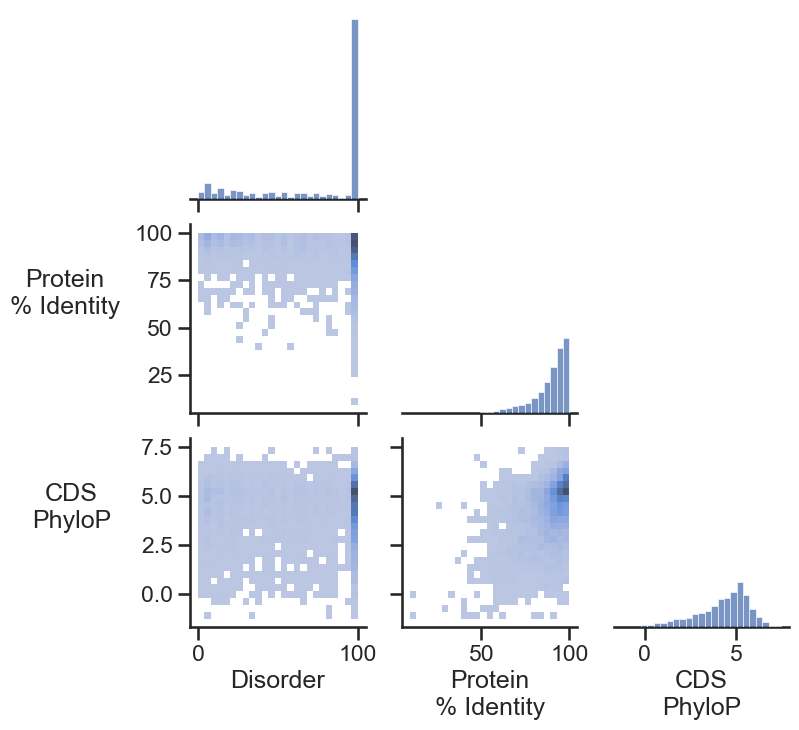

In [69]:
sns.set_context('talk')
pairplot_df = tiled_lambert_with_phylop[["percent_disorder", "avg_percent_identity", "average_PhyloP"]]
pairplot_df = pairplot_df.rename(columns = {"percent_disorder" : "Disorder",
                                            "avg_percent_identity" : "Protein\n% Identity",
                                            "average_PhyloP" : "CDS\nPhyloP"})

g = sns.pairplot(pairplot_df, kind = "hist", diag_kws={"bins" : 25}, plot_kws={"bins" : 25}, corner = True)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 50)

plt.show()

ValueError: autodetected range of [nan, nan] is not finite

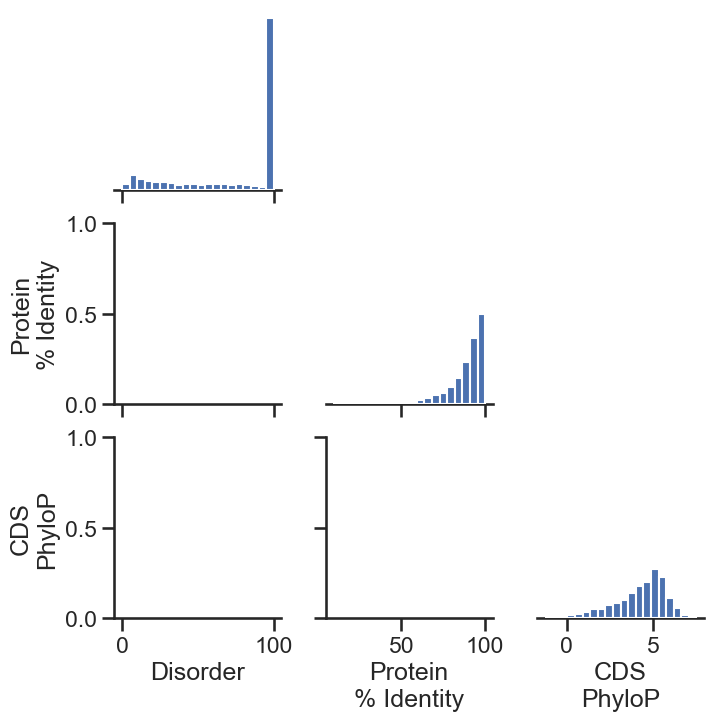

In [70]:
#https://stackoverflow.com/questions/43924280/pair-plot-with-heat-maps-possibly-logarithmic
g = sns.PairGrid(pairplot_df, corner = True)
g.map_diag(plt.hist, bins=20)

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)

g.map_offdiag(pairgrid_heatmap, bins=20, norm=LogNorm())


for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 45)

In [ ]:
#https://stackoverflow.com/questions/43924280/pair-plot-with-heat-maps-possibly-logarithmic
g = sns.PairGrid(pairplot_df, corner = True)
g.map_diag(plt.hist, bins=20)

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)

g.map_offdiag(pairgrid_heatmap, bins=20, norm=LogNorm());

def add_best_fit_line(x, y, **kws):
    sns.regplot(x=x, y=y, scatter=False, line_kws={'linewidth': 2, 'color' : 'red'}, **kws)

# Apply the best fit line function to the off-diagonal plots
g.map_offdiag(add_best_fit_line)

# Show the plot
plt.show()

# 5. MTR

In [34]:
cds_mtr = []

cds_paths = glob.glob("../soto_analysis/outputs/mutations/cds_mtr/*")

for path in cds_paths:
    ENST = path.split("/")[-1].split(".bed")[0]

    try:
        df = pd.read_csv(path, sep = "\t", header = None)
        cds_mtr.append(df)
    except pd.errors.EmptyDataError:
        print(ENST, " is empty and has been skipped.")

cds_mtr = pd.concat(cds_mtr)
cds_mtr = cds_mtr.rename(columns = {3: "ENST", 8: "MTR"})
cds_mtr

ENST00000422806  is empty and has been skipped.
ENST00000425953  is empty and has been skipped.
ENST00000468660  is empty and has been skipped.
ENST00000379044  is empty and has been skipped.
ENST00000376983  is empty and has been skipped.
ENST00000338637  is empty and has been skipped.
ENST00000400120  is empty and has been skipped.
ENST00000540921  is empty and has been skipped.
ENST00000376207  is empty and has been skipped.
ENST00000283891  is empty and has been skipped.
ENST00000321217  is empty and has been skipped.
ENST00000534327  is empty and has been skipped.
ENST00000326624  is empty and has been skipped.
ENST00000383070  is empty and has been skipped.
ENST00000339249  is empty and has been skipped.
ENST00000370766  is empty and has been skipped.
ENST00000310125  is empty and has been skipped.
ENST00000373125  is empty and has been skipped.
ENST00000315869  is empty and has been skipped.
ENST00000376670  is empty and has been skipped.
ENST00000374259  is empty and has been s

,0,1,2,ENST,4,5,6,7,MTR
0,2,27149136,27149137,ENST00000296096,1,2,27149136,27149137,0.963783
1,2,27149137,27149138,ENST00000296096,1,2,27149137,27149138,0.963783
2,2,27149139,27149140,ENST00000296096,1,2,27149139,27149140,0.938410
3,2,27149140,27149141,ENST00000296096,1,2,27149140,27149141,0.938410
4,2,27149141,27149142,ENST00000296096,1,2,27149141,27149142,0.938410
...,...,...,...,...,...,...,...,...,...
3131,16,49730859,49730860,ENST00000561648,-1,16,49730859,49730860,0.971544
3132,16,49730860,49730861,ENST00000561648,-1,16,49730860,49730861,0.971544
3133,16,49730861,49730862,ENST00000561648,-1,16,49730861,49730862,0.937262
3134,16,49730862,49730863,ENST00000561648,-1,16,49730862,49730863,0.937262


In [35]:
def get_mtr_scores(ENST, cds_mtr = cds_mtr):
    ENST_mtr = cds_mtr[cds_mtr["ENST"] == ENST]
    if len(ENST_mtr) > 0:
        if ENST_mtr[4].iloc[0] == -1:
            ascending = False
        else: 
            ascending = True
            
        ENST_mtr = ENST_mtr.sort_values(by = 1, ascending = ascending)
        
        #ENST_mtr["cds_nt"] = np.arange(len(cds_mtr)) / 3
        ENST_mtr = ENST_mtr.reset_index(drop = True)

        # making sure one row per pos
        start = ENST_mtr[1].iloc[0]
        end = ENST_mtr[1].iloc[-1]

        pos_df = get_phylop_scores(ENST)[[1]]
        ENST_mtr = pd.merge(pos_df, ENST_mtr, how = "left")
    
        return ENST_mtr

In [36]:
get_phylop_scores("ENST00000259803")

,0,1,2,ENST,4,5,6,7,PhyloP,cds_nt
0,6,53145632,53145633,ENST00000259803,-1,6,53145632,53145633,2.331,0.000000
1,6,53145631,53145632,ENST00000259803,-1,6,53145631,53145632,6.291,0.333333
2,6,53145630,53145631,ENST00000259803,-1,6,53145630,53145631,4.655,0.666667
3,6,53145629,53145630,ENST00000259803,-1,6,53145629,53145630,8.805,1.000000
4,6,53145628,53145629,ENST00000259803,-1,6,53145628,53145629,2.459,1.333333
...,...,...,...,...,...,...,...,...,...,...
1306,6,53128210,53128211,ENST00000259803,-1,6,53128210,53128211,0.398,435.333333
1307,6,53128209,53128210,ENST00000259803,-1,6,53128209,53128210,5.710,435.666667
1308,6,53128208,53128209,ENST00000259803,-1,6,53128208,53128209,1.790,436.000000
1309,6,53128207,53128208,ENST00000259803,-1,6,53128207,53128208,4.649,436.333333


In [37]:
get_mtr_scores("ENST00000259803")

,1,0,2,ENST,4,5,6,7,MTR
0,53145632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53145631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53145630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53145629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53145628,6.0,53145629.0,ENST00000259803,-1.0,6.0,53145628.0,53145629.0,1.051194
...,...,...,...,...,...,...,...,...,...
1306,53128210,6.0,53128211.0,ENST00000259803,-1.0,6.0,53128210.0,53128211.0,0.987538
1307,53128209,6.0,53128210.0,ENST00000259803,-1.0,6.0,53128209.0,53128210.0,0.987538
1308,53128208,6.0,53128209.0,ENST00000259803,-1.0,6.0,53128208.0,53128209.0,0.987538
1309,53128207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
tile_mtrs = []

for ENST in set(cds_mtr["ENST"]):
    ENST_mtr = get_mtr_scores(ENST)
    
    starts, ends, mtr_lists, avg_mtr = [], [], [], []
    
    for i in np.arange(len(ENST_mtr) - 120 + 1):
        mtr_lists.append(list(ENST_mtr["MTR"][i : i + 120]))
        avg_mtr.append(np.mean(list(ENST_mtr["MTR"][i : i + 120])))
        starts.append(i)
        ends.append(i + 40)
    
    tile_mtrs.append(pd.DataFrame({"ENST" : ENST, 
                  "StartPosition" : starts, 
                  "EndPosition" : ends, 
                  "MTR" : mtr_lists,
                "average_MTR" : avg_mtr}))

tile_mtrs = pd.concat(tile_mtrs)
tile_mtrs

,ENST,StartPosition,EndPosition,MTR,average_MTR
0,ENST00000262525,0,40,"[nan, nan, nan, nan, 0.99251245538987, 0.99251...",NaN
1,ENST00000262525,1,41,"[nan, nan, nan, 0.99251245538987, 0.9925124553...",NaN
2,ENST00000262525,2,42,"[nan, nan, 0.99251245538987, 0.99251245538987,...",NaN
3,ENST00000262525,3,43,"[nan, 0.99251245538987, 0.99251245538987, 0.99...",NaN
4,ENST00000262525,4,44,"[0.99251245538987, 0.99251245538987, 0.9925124...",NaN
...,...,...,...,...,...
1157,ENST00000440367,1157,1197,"[1.003827419005317, 1.003827419005317, nan, 0....",NaN
1158,ENST00000440367,1158,1198,"[1.003827419005317, nan, 0.9806613279935864, 0...",NaN
1159,ENST00000440367,1159,1199,"[nan, 0.9806613279935864, 0.9806613279935864, ...",NaN
1160,ENST00000440367,1160,1200,"[0.9806613279935864, 0.9806613279935864, nan, ...",NaN


In [39]:
tile_mtrs = tile_mtrs.reset_index(drop = True)
tile_mtrs

,ENST,StartPosition,EndPosition,MTR,average_MTR
0,ENST00000262525,0,40,"[nan, nan, nan, nan, 0.99251245538987, 0.99251...",NaN
1,ENST00000262525,1,41,"[nan, nan, nan, 0.99251245538987, 0.9925124553...",NaN
2,ENST00000262525,2,42,"[nan, nan, 0.99251245538987, 0.99251245538987,...",NaN
3,ENST00000262525,3,43,"[nan, 0.99251245538987, 0.99251245538987, 0.99...",NaN
4,ENST00000262525,4,44,"[0.99251245538987, 0.99251245538987, 0.9925124...",NaN
...,...,...,...,...,...
2491933,ENST00000440367,1157,1197,"[1.003827419005317, 1.003827419005317, nan, 0....",NaN
2491934,ENST00000440367,1158,1198,"[1.003827419005317, nan, 0.9806613279935864, 0...",NaN
2491935,ENST00000440367,1159,1199,"[nan, 0.9806613279935864, 0.9806613279935864, ...",NaN
2491936,ENST00000440367,1160,1200,"[0.9806613279935864, 0.9806613279935864, nan, ...",NaN


In [71]:
import math 

avg_mtrs = []
for i in tile_mtrs.index:
    avg_mtrs.append(np.mean([val for val in tile_mtrs["MTR"].iloc[i] if not math.isnan(val)]))
    if i % 50000 == 0:
        print(i)
tile_mtrs["average_MTR"] = avg_mtrs
tile_mtrs

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
1200000
1250000
1300000
1350000
1400000
1450000
1500000
1550000
1600000
1650000
1700000
1750000
1800000
1850000
1900000
1950000
2000000
2050000
2100000
2150000
2200000
2250000
2300000
2350000
2400000
2450000


,ENST,StartPosition,EndPosition,MTR,average_MTR
0,ENST00000262525,0,40,"[nan, nan, nan, nan, 0.99251245538987, 0.99251...",1.000843
1,ENST00000262525,1,41,"[nan, nan, nan, 0.99251245538987, 0.9925124553...",1.000843
2,ENST00000262525,2,42,"[nan, nan, 0.99251245538987, 0.99251245538987,...",1.001962
3,ENST00000262525,3,43,"[nan, 0.99251245538987, 0.99251245538987, 0.99...",1.003058
4,ENST00000262525,4,44,"[0.99251245538987, 0.99251245538987, 0.9925124...",1.003058
...,...,...,...,...,...
2491933,ENST00000440367,1157,1197,"[1.003827419005317, 1.003827419005317, nan, 0....",0.940591
2491934,ENST00000440367,1158,1198,"[1.003827419005317, nan, 0.9806613279935864, 0...",0.939995
2491935,ENST00000440367,1159,1199,"[nan, 0.9806613279935864, 0.9806613279935864, ...",0.939387
2491936,ENST00000440367,1160,1200,"[0.9806613279935864, 0.9806613279935864, nan, ...",0.939387


In [72]:
tile_mtrs = tile_mtrs.dropna()
tile_mtrs

,ENST,StartPosition,EndPosition,MTR,average_MTR
0,ENST00000262525,0,40,"[nan, nan, nan, nan, 0.99251245538987, 0.99251...",1.000843
1,ENST00000262525,1,41,"[nan, nan, nan, 0.99251245538987, 0.9925124553...",1.000843
2,ENST00000262525,2,42,"[nan, nan, 0.99251245538987, 0.99251245538987,...",1.001962
3,ENST00000262525,3,43,"[nan, 0.99251245538987, 0.99251245538987, 0.99...",1.003058
4,ENST00000262525,4,44,"[0.99251245538987, 0.99251245538987, 0.9925124...",1.003058
...,...,...,...,...,...
2491933,ENST00000440367,1157,1197,"[1.003827419005317, 1.003827419005317, nan, 0....",0.940591
2491934,ENST00000440367,1158,1198,"[1.003827419005317, nan, 0.9806613279935864, 0...",0.939995
2491935,ENST00000440367,1159,1199,"[nan, 0.9806613279935864, 0.9806613279935864, ...",0.939387
2491936,ENST00000440367,1160,1200,"[0.9806613279935864, 0.9806613279935864, nan, ...",0.939387


In [73]:
# lose 6k
tiled_lambert_with_mtr = pd.merge(tiled_lambert_with_phylop, tile_mtrs)
tiled_lambert_with_mtr

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP,MTR,average_MTR
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,100.0,A6NJG6,ARGFX,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384,"[-4.108, -0.452, 0.105, -0.257, 0.559, -0.061,...",0.029225,"[nan, nan, 0.9895489511828596, 0.9895489511828...",1.083595
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,100.0,A6NJG6,ARGFX,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384,"[2.4, 0.686, -0.809, 0.699, 0.223, 0.643, 0.73...",-0.050108,"[nan, 1.0634275136025553, 1.0634275136025553, ...",1.117582
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,12.5,A6NJG6,ARGFX,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384,"[0.315, 2.006, 0.604, 2.033, 1.516, -0.445, -0...",-0.083100,"[1.1424670562059671, 1.1424670562059671, nan, ...",1.140393
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,72.5,A6NJG6,ARGFX,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384,"[-0.6, -0.014, 0.807, -0.171, -0.605, 0.8, 0.4...",-0.170567,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.972334
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,100.0,A6NJG6,ARGFX,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384,"[-0.019, -0.757, -0.129, -0.074, -0.018, 0.625...",0.087592,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.974269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,0,0,2,0,4,1,...,100.0,Q9Y6Y1,CAMTA1,"[98.68995633187772, 66.15720524017468, 98.6899...",89.743450,ENST00000303635,"[6.337, 8.763, 6.311, 6.311, 7.101, 6.337, 6.3...",4.736008,"[nan, 0.930834255564338, 0.930834255564338, 0....",0.988047
5693,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792,"[0.952982120371318, 0.952982120371318, 0.95298...",0.984025
5694,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635,"[8.763, 0.745, -0.218, -0.687, 1.504, 2.653, -...",4.331908,"[1.0576559198055022, 1.0576559198055022, 1.070...",0.923888
5695,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635,"[0.502, 2.957, 6.331, 4.674, 1.191, -0.333, 8....",4.150142,"[nan, 0.9778125338641848, 0.9778125338641848, ...",0.851557


In [77]:
tiled_lambert_with_mtr = tiled_lambert_with_mtr.dropna()
tiled_lambert_with_mtr

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,percent_disorder,uniprotID,gene,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP,MTR,average_MTR
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,100.0,A6NJG6,ARGFX,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384,"[-4.108, -0.452, 0.105, -0.257, 0.559, -0.061,...",0.029225,"[nan, nan, 0.9895489511828596, 0.9895489511828...",1.083595
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,100.0,A6NJG6,ARGFX,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384,"[2.4, 0.686, -0.809, 0.699, 0.223, 0.643, 0.73...",-0.050108,"[nan, 1.0634275136025553, 1.0634275136025553, ...",1.117582
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,12.5,A6NJG6,ARGFX,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384,"[0.315, 2.006, 0.604, 2.033, 1.516, -0.445, -0...",-0.083100,"[1.1424670562059671, 1.1424670562059671, nan, ...",1.140393
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,72.5,A6NJG6,ARGFX,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384,"[-0.6, -0.014, 0.807, -0.171, -0.605, 0.8, 0.4...",-0.170567,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.972334
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,100.0,A6NJG6,ARGFX,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384,"[-0.019, -0.757, -0.129, -0.074, -0.018, 0.625...",0.087592,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.974269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,0,0,2,0,4,1,...,100.0,Q9Y6Y1,CAMTA1,"[98.68995633187772, 66.15720524017468, 98.6899...",89.743450,ENST00000303635,"[6.337, 8.763, 6.311, 6.311, 7.101, 6.337, 6.3...",4.736008,"[nan, 0.930834255564338, 0.930834255564338, 0....",0.988047
5693,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,80.0,Q9Y6Y1,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792,"[0.952982120371318, 0.952982120371318, 0.95298...",0.984025
5694,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,0.0,Q9Y6Y1,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635,"[8.763, 0.745, -0.218, -0.687, 1.504, 2.653, -...",4.331908,"[1.0576559198055022, 1.0576559198055022, 1.070...",0.923888
5695,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,2.5,Q9Y6Y1,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635,"[0.502, 2.957, 6.331, 4.674, 1.191, -0.333, 8....",4.150142,"[nan, 0.9778125338641848, 0.9778125338641848, ...",0.851557


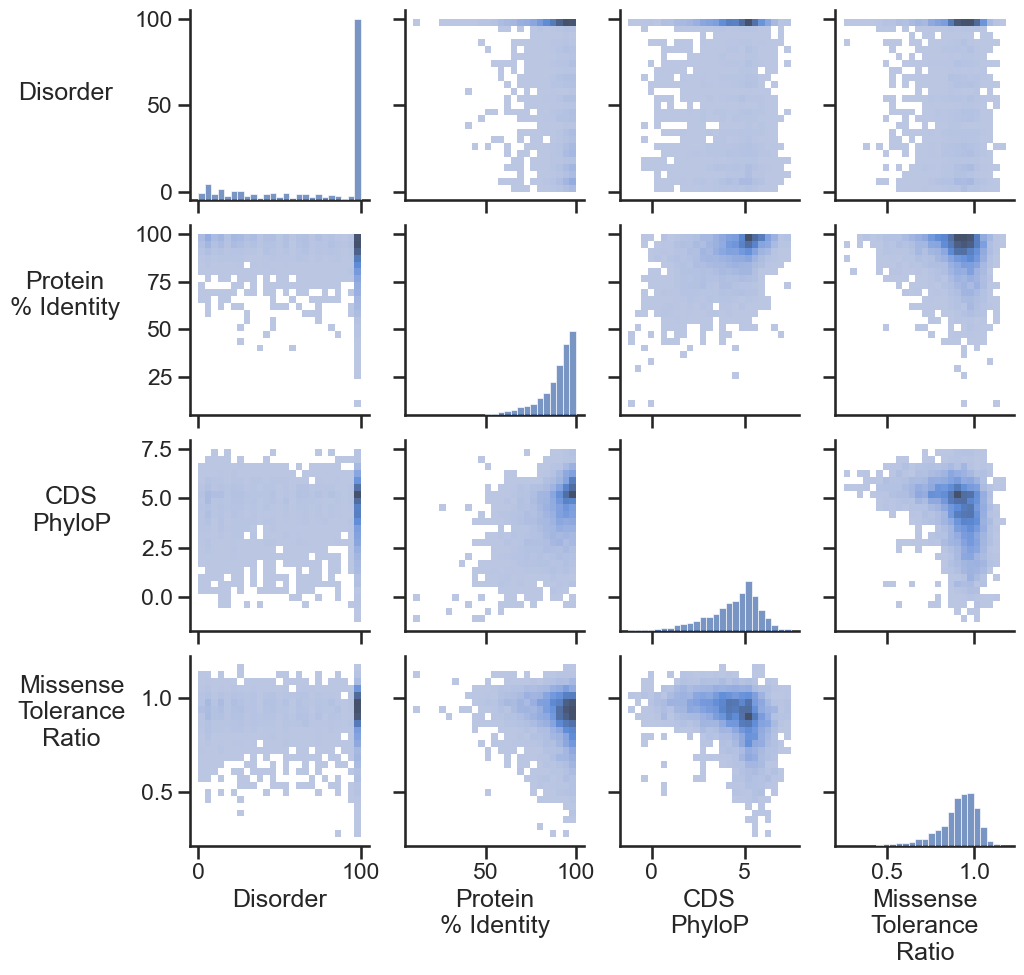

In [78]:
sns.set_context('talk')
pairplot_df = tiled_lambert_with_mtr[["percent_disorder", "avg_percent_identity", "average_PhyloP", "average_MTR"]]
pairplot_df = pairplot_df.rename(columns = {"percent_disorder" : "Disorder",
                                            "avg_percent_identity" : "Protein\n% Identity",
                                            "average_PhyloP" : "CDS\nPhyloP",
                                           "average_MTR" : "Missense\nTolerance\nRatio"})

g = sns.pairplot(pairplot_df, kind = "hist", diag_kws={"bins" : 25}, plot_kws={"bins" : 25})

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 50)

plt.show()

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x127d63520>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyter_env/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


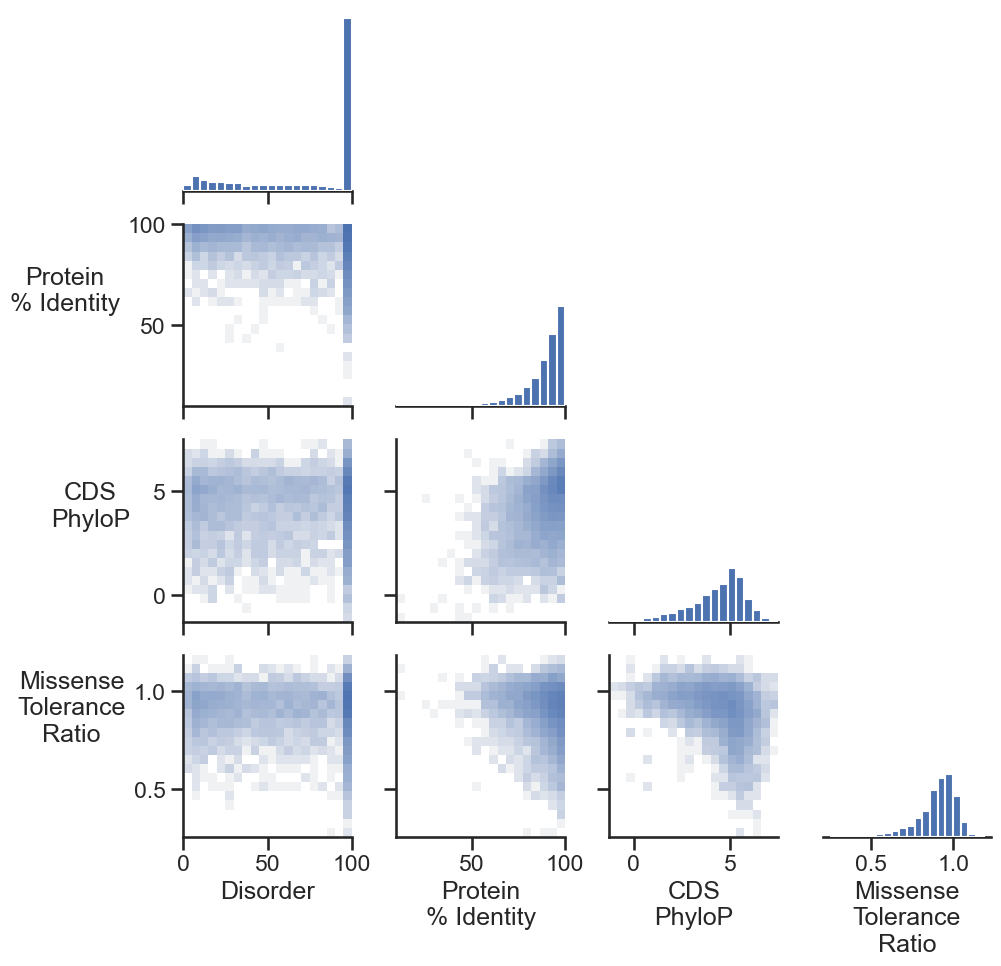

In [79]:
#https://stackoverflow.com/questions/43924280/pair-plot-with-heat-maps-possibly-logarithmic
g = sns.PairGrid(pairplot_df, corner = True)
g.map_diag(plt.hist, bins=20)

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)

g.map_offdiag(pairgrid_heatmap, bins=20, norm=LogNorm())

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 45)

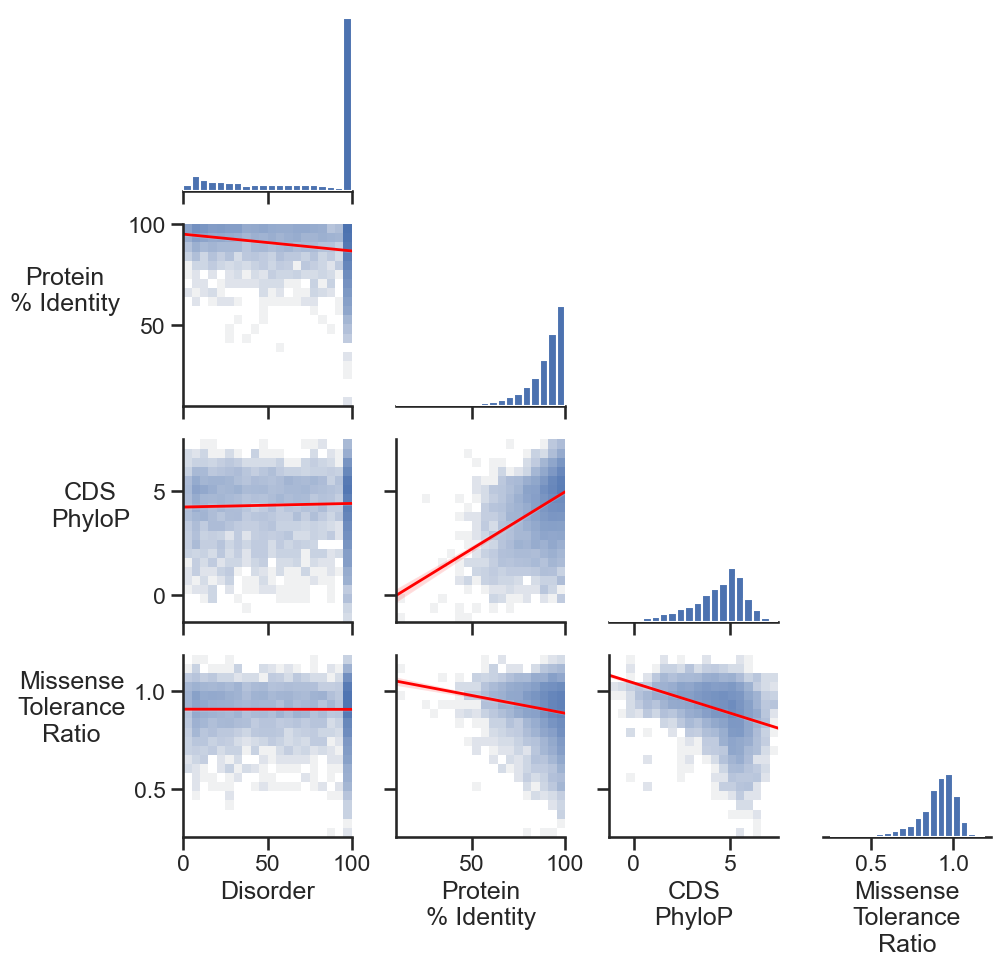

In [80]:
#https://stackoverflow.com/questions/43924280/pair-plot-with-heat-maps-possibly-logarithmic
g = sns.PairGrid(pairplot_df, corner = True)
g.map_diag(plt.hist, bins=20)

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)

g.map_offdiag(pairgrid_heatmap, bins=20, norm=LogNorm());

def add_best_fit_line(x, y, **kws):
    sns.regplot(x=x, y=y, scatter=False, line_kws={'linewidth': 2, 'color' : 'red'}, **kws)

# Apply the best fit line function to the off-diagonal plots
g.map_offdiag(add_best_fit_line)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 45)
        
# Show the plot
plt.show()

# 6. Add overlap with ADs

In [81]:
tiled_lambert_with_mtr["Start"] = tiled_lambert_with_mtr["StartPosition"]
tiled_lambert_with_mtr["End"] = tiled_lambert_with_mtr["EndPosition"]
tiled_lambert_with_mtr

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,gene,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP,MTR,average_MTR,Start,End
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,ARGFX,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384,"[-4.108, -0.452, 0.105, -0.257, 0.559, -0.061,...",0.029225,"[nan, nan, 0.9895489511828596, 0.9895489511828...",1.083595,0,40
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,ARGFX,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384,"[2.4, 0.686, -0.809, 0.699, 0.223, 0.643, 0.73...",-0.050108,"[nan, 1.0634275136025553, 1.0634275136025553, ...",1.117582,40,80
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,ARGFX,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384,"[0.315, 2.006, 0.604, 2.033, 1.516, -0.445, -0...",-0.083100,"[1.1424670562059671, 1.1424670562059671, nan, ...",1.140393,80,120
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,ARGFX,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384,"[-0.6, -0.014, 0.807, -0.171, -0.605, 0.8, 0.4...",-0.170567,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.972334,120,160
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,ARGFX,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384,"[-0.019, -0.757, -0.129, -0.074, -0.018, 0.625...",0.087592,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.974269,160,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,0,0,2,0,4,1,...,CAMTA1,"[98.68995633187772, 66.15720524017468, 98.6899...",89.743450,ENST00000303635,"[6.337, 8.763, 6.311, 6.311, 7.101, 6.337, 6.3...",4.736008,"[nan, 0.930834255564338, 0.930834255564338, 0....",0.988047,1440,1480
5693,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,CAMTA1,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792,"[0.952982120371318, 0.952982120371318, 0.95298...",0.984025,1480,1520
5694,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,CAMTA1,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635,"[8.763, 0.745, -0.218, -0.687, 1.504, 2.653, -...",4.331908,"[1.0576559198055022, 1.0576559198055022, 1.070...",0.923888,1520,1560
5695,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,CAMTA1,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635,"[0.502, 2.957, 6.331, 4.674, 1.191, -0.333, 8....",4.150142,"[nan, 0.9778125338641848, 0.9778125338641848, ...",0.851557,1560,1600


In [82]:
all_known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms.csv")
# Only keep ADs on Lambert TFs
known_ADs = all_known_ADs[all_known_ADs["TileType"] == "TF"]
known_ADs = known_ADs[known_ADs["uniprotID"].isin(tiled_lambert_with_mtr["uniprotID"])]
# Preparing known AD coords for merge
known_AD_coords = known_ADs[["uniprotID", "Start", "End"]]
known_AD_coords = known_AD_coords.rename(columns = {"Start" : "annot_Start", "End" : "annot_End"})
known_AD_coords

,uniprotID,annot_Start,annot_End
1,Q8IUX7,1088,1158
2,Q8WYP5,1445,1698
3,P35869,118,126
4,P35869,266,268
5,P35869,532,848
...,...,...,...
737,Q9H582,902,981
738,Q8N1G0,2,81
739,P17040,262,341
742,Q2QGD7,579,688


In [83]:
def add_overlap_status(df, domain_list, col_type, min_overlap = 32, col_name_suffix =  "_suffic_overlap"):
    # Keep rows of adhunter with annots
    # Calculate interval overlap
    # If there is overlap of at least 80% (so >= 32 residues) then there is sufficient overlap
    df_with_annots = pd.merge(df, domain_list, on = "uniprotID")
    df_with_annots["overlap_length"] =  df_with_annots[['End', 'annot_End']].min(axis=1) - df_with_annots[['Start', 'annot_Start']].max(axis=1)
    df_with_annots[col_type+ "_suffic_overlap"] = df_with_annots["overlap_length"] >= min_overlap
    #display(df_with_annots)
    
    # Keep first of each tile, such that if there is an overlappign tile it is saved
    df_with_annots = df_with_annots.sort_values(by = col_type+ "_suffic_overlap", ascending = False)
    df_with_annots = df_with_annots.drop_duplicates(subset = ["ProteinWindowSeq"], keep = "first")
    #display(df_with_annots)
    
    # Add info back to full tile table (includes TFs with no annotated ADs)
    #display(df)
    df = pd.merge(df, df_with_annots[["ProteinWindowSeq", col_type+ "_suffic_overlap"]], how = "left")
    df = df.fillna(False)
    return df

In [84]:
tiled_lambert_with_overlap = add_overlap_status(tiled_lambert_with_mtr, known_AD_coords, "AD")
tiled_lambert_with_overlap

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP,MTR,average_MTR,Start,End,AD_suffic_overlap
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384,"[-4.108, -0.452, 0.105, -0.257, 0.559, -0.061,...",0.029225,"[nan, nan, 0.9895489511828596, 0.9895489511828...",1.083595,0,40,False
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384,"[2.4, 0.686, -0.809, 0.699, 0.223, 0.643, 0.73...",-0.050108,"[nan, 1.0634275136025553, 1.0634275136025553, ...",1.117582,40,80,False
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384,"[0.315, 2.006, 0.604, 2.033, 1.516, -0.445, -0...",-0.083100,"[1.1424670562059671, 1.1424670562059671, nan, ...",1.140393,80,120,False
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384,"[-0.6, -0.014, 0.807, -0.171, -0.605, 0.8, 0.4...",-0.170567,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.972334,120,160,False
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384,"[-0.019, -0.757, -0.129, -0.074, -0.018, 0.625...",0.087592,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.974269,160,200,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,0,0,2,0,4,1,...,"[98.68995633187772, 66.15720524017468, 98.6899...",89.743450,ENST00000303635,"[6.337, 8.763, 6.311, 6.311, 7.101, 6.337, 6.3...",4.736008,"[nan, 0.930834255564338, 0.930834255564338, 0....",0.988047,1440,1480,False
5294,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792,"[0.952982120371318, 0.952982120371318, 0.95298...",0.984025,1480,1520,False
5295,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635,"[8.763, 0.745, -0.218, -0.687, 1.504, 2.653, -...",4.331908,"[1.0576559198055022, 1.0576559198055022, 1.070...",0.923888,1520,1560,False
5296,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635,"[0.502, 2.957, 6.331, 4.674, 1.191, -0.333, 8....",4.150142,"[nan, 0.9778125338641848, 0.9778125338641848, ...",0.851557,1560,1600,False


In [85]:
tiled_lambert_with_overlap.columns

Index(['ProteinWindowSeq', 'GeneName', 'StartPosition', 'EndPosition', 'W',
       'F', 'Y', 'M', 'L', 'Q', 'K', 'R', 'D', 'E', 'Charge',
       'percent_disorder', 'uniprotID', 'gene', 'percent_identity',
       'avg_percent_identity', 'ENST', 'PhyloP', 'average_PhyloP', 'MTR',
       'average_MTR', 'Start', 'End', 'AD_suffic_overlap'],
      dtype='object')

In [86]:
tiled_lambert_with_overlap

,ProteinWindowSeq,GeneName,StartPosition,EndPosition,W,F,Y,M,L,Q,...,percent_identity,avg_percent_identity,ENST,PhyloP,average_PhyloP,MTR,average_MTR,Start,End,AD_suffic_overlap
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,0,40,0,2,1,3,2,2,...,"[10.416666666666666, 4.166666666666667, 65.833...",34.687500,ENST00000334384,"[-4.108, -0.452, 0.105, -0.257, 0.559, -0.061,...",0.029225,"[nan, nan, 0.9895489511828596, 0.9895489511828...",1.083595,0,40,False
1,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,40,80,0,0,1,0,3,0,...,"[6.25, 6.666666666666667, 10.416666666666666, ...",9.458333,ENST00000334384,"[2.4, 0.686, -0.809, 0.699, 0.223, 0.643, 0.73...",-0.050108,"[nan, 1.0634275136025553, 1.0634275136025553, ...",1.117582,40,80,False
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,80,120,0,3,1,1,7,4,...,"[52.5, 84.16666666666667, 86.66666666666667, 7...",65.270833,ENST00000334384,"[0.315, 2.006, 0.604, 2.033, 1.516, -0.445, -0...",-0.083100,"[1.1424670562059671, 1.1424670562059671, nan, ...",1.140393,80,120,False
3,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,120,160,1,2,0,0,2,7,...,"[77.08333333333333, 73.33333333333333, 82.5, 3...",60.614583,ENST00000334384,"[-0.6, -0.014, 0.807, -0.171, -0.605, 0.8, 0.4...",-0.170567,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.972334,120,160,False
4,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,160,200,2,3,2,0,2,1,...,"[30.0, 72.91666666666667, 4.166666666666667, 4...",48.104167,ENST00000334384,"[-0.019, -0.757, -0.129, -0.074, -0.018, 0.625...",0.087592,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.974269,160,200,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1440,1480,0,0,2,0,4,1,...,"[98.68995633187772, 66.15720524017468, 98.6899...",89.743450,ENST00000303635,"[6.337, 8.763, 6.311, 6.311, 7.101, 6.337, 6.3...",4.736008,"[nan, 0.930834255564338, 0.930834255564338, 0....",0.988047,1440,1480,False
5294,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1480,1520,1,3,0,0,4,1,...,"[94.5414847161572, 75.9825327510917, 81.877729...",94.546943,ENST00000303635,"[5.855, 8.763, 8.763, 1.844, 8.87, 6.311, 6.94...",4.221792,"[0.952982120371318, 0.952982120371318, 0.95298...",0.984025,1480,1520,False
5295,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1520,1560,0,1,3,0,3,5,...,"[98.471615720524, 98.471615720524, 98.47161572...",98.149563,ENST00000303635,"[8.763, 0.745, -0.218, -0.687, 1.504, 2.653, -...",4.331908,"[1.0576559198055022, 1.0576559198055022, 1.070...",0.923888,1520,1560,False
5296,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1560,1600,0,2,5,1,3,6,...,"[98.0349344978166, 97.37991266375546, 98.03493...",98.029476,ENST00000303635,"[0.502, 2.957, 6.331, 4.674, 1.191, -0.333, 8....",4.150142,"[nan, 0.9778125338641848, 0.9778125338641848, ...",0.851557,1560,1600,False


In [87]:
input_data = tiled_lambert_with_overlap[["GeneName", "ProteinWindowSeq", "StartPosition", "EndPosition", "percent_disorder", "avg_percent_identity", "average_PhyloP", "average_MTR", "AD_suffic_overlap"]]
input_data

,GeneName,ProteinWindowSeq,StartPosition,EndPosition,percent_disorder,avg_percent_identity,average_PhyloP,average_MTR,AD_suffic_overlap
0,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,0,40,100.0,34.687500,0.029225,1.083595,False
1,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,40,80,100.0,9.458333,-0.050108,1.117582,False
2,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,80,120,12.5,65.270833,-0.083100,1.140393,False
3,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,TVKVWFRNRRFKLKKQQQQQSAKQRNQILPSKKNVPTSPR,120,160,72.5,60.614583,-0.170567,0.972334,False
4,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,TSPSPYAFSPVISDFYSSLPSQPLDPSNWAWNSTFTESST,160,200,100.0,48.104167,0.087592,0.974269,True
...,...,...,...,...,...,...,...,...,...
5293,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,ASYLADADCLPSAAQIRSAYNEPLTPSSNTSLSPVGSPVS,1440,1480,100.0,89.743450,4.736008,0.988047,False
5294,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,EIAFEKPNLPSAADWSEFLSASTSEKVENEFAQLTLSDHE,1480,1520,80.0,94.546943,4.221792,0.984025,False
5295,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,QRELYEAARLVQTAFRKYKGRPLREQQEVAAAVIQRCYRK,1520,1560,0.0,98.149563,4.331908,0.923888,False
5296,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,YKQYALYKKMTQAAILIQSKFRSYYEQKKFQQSRRAAVLI,1560,1600,2.5,98.029476,4.150142,0.851557,False


In [88]:
# input_data.groupby("AD_suffic_overlap").mean()

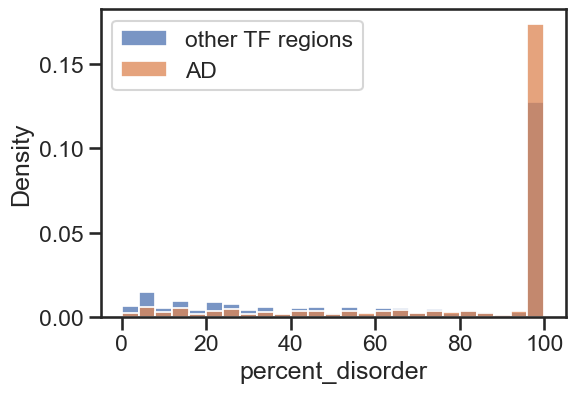

In [89]:
sns.histplot(input_data[input_data["AD_suffic_overlap"] == False]["percent_disorder"], stat = "density", bins = 25, label = "other TF regions")
sns.histplot(input_data[input_data["AD_suffic_overlap"] == True]["percent_disorder"], stat = "density", bins = 25, label = "AD")
plt.legend()

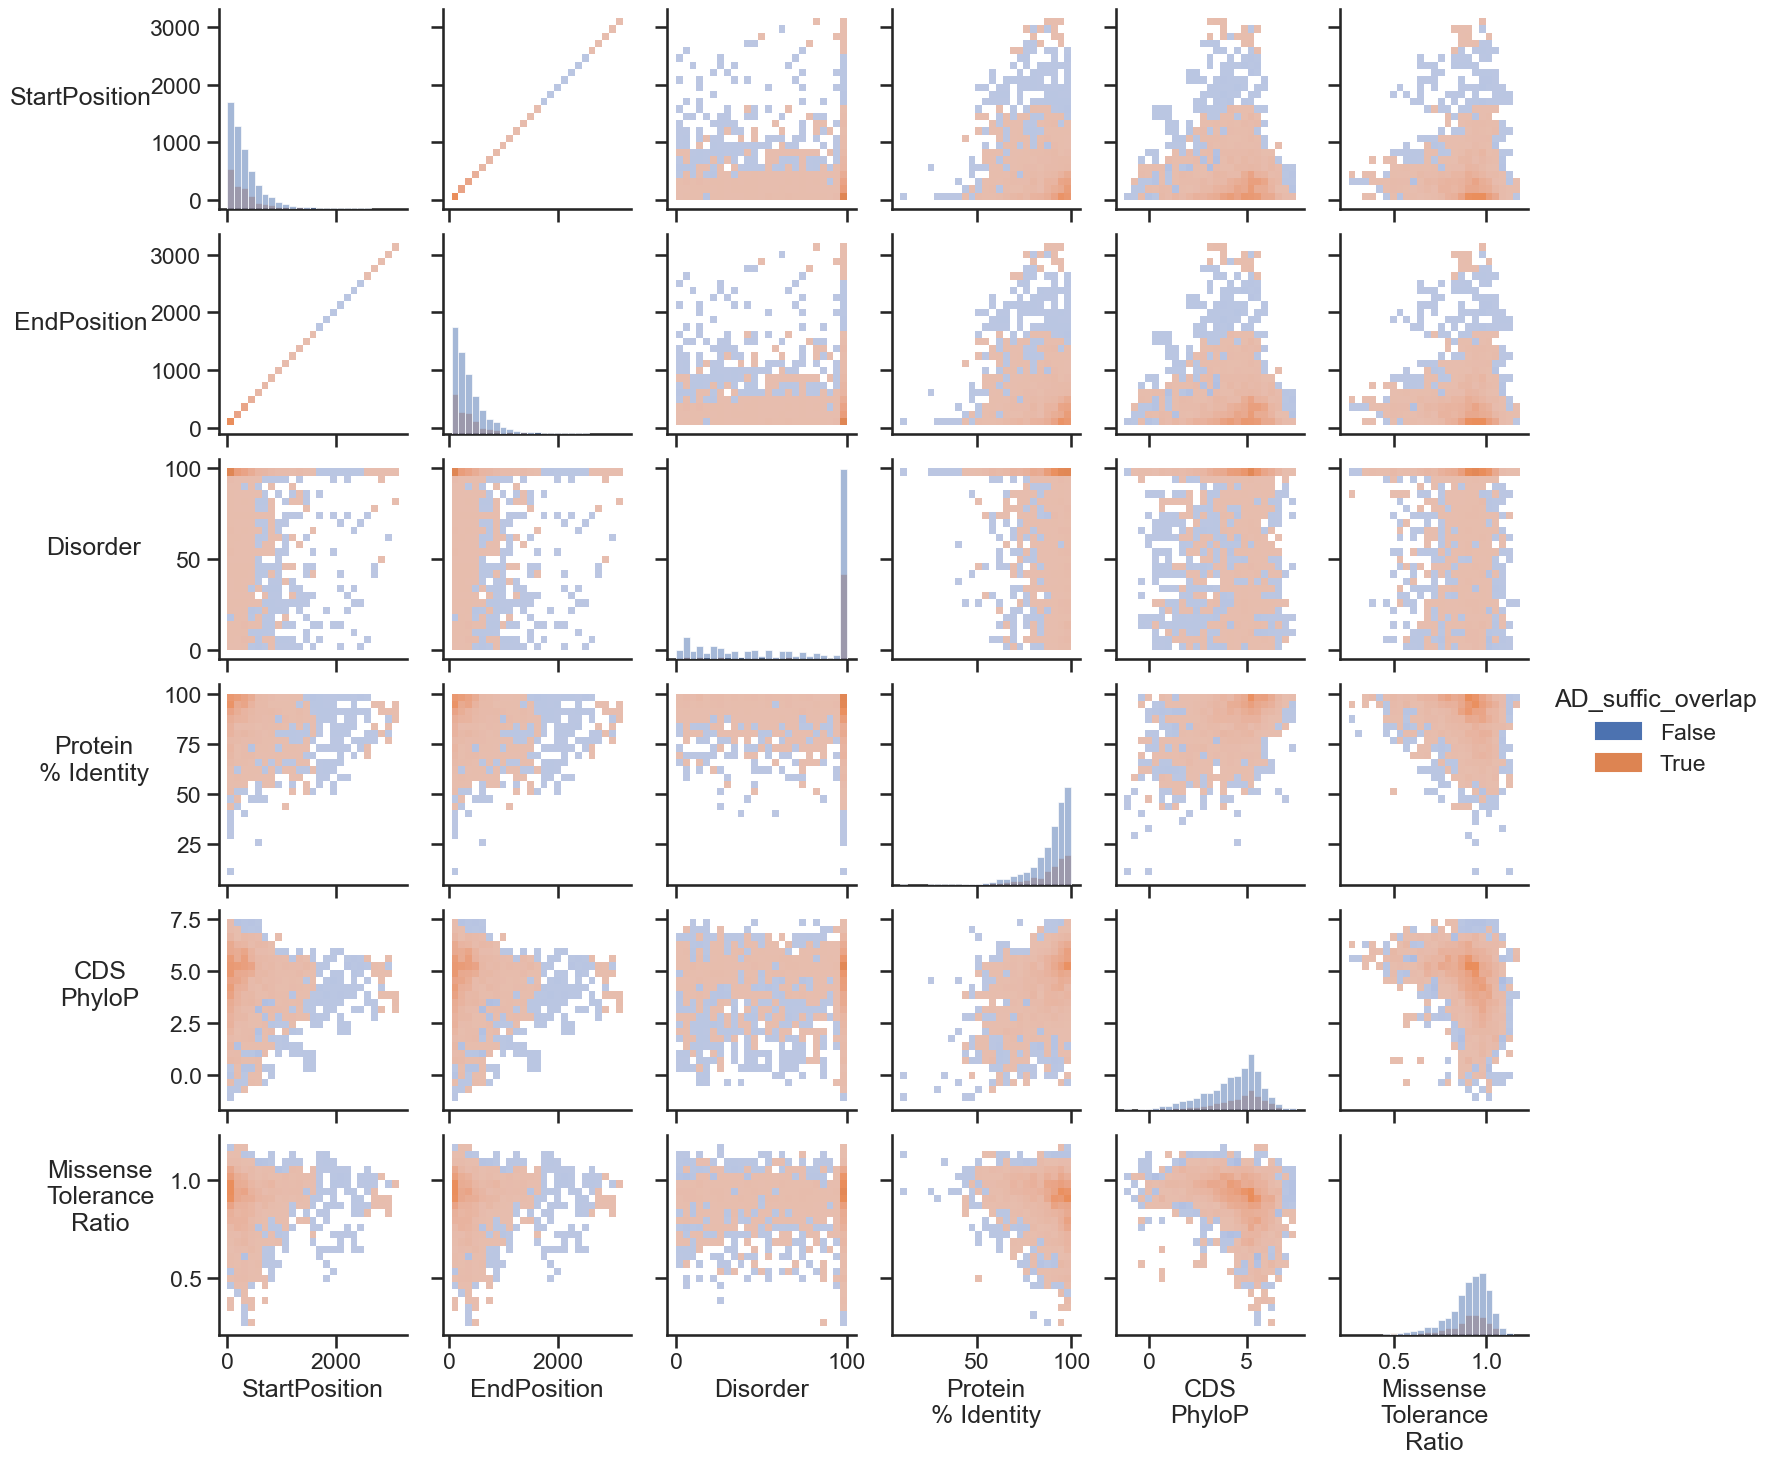

In [90]:
sns.set_context('talk')
pairplot_df = input_data
pairplot_df = pairplot_df.rename(columns = {"percent_disorder" : "Disorder",
                                            "avg_percent_identity" : "Protein\n% Identity",
                                            "average_PhyloP" : "CDS\nPhyloP",
                                           "average_MTR" : "Missense\nTolerance\nRatio"})

g = sns.pairplot(pairplot_df, kind = "hist", diag_kws={"bins" : 25, "common_norm" : False}, plot_kws={"bins" : 25}, hue = "AD_suffic_overlap", corner = False)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 50)

plt.show()

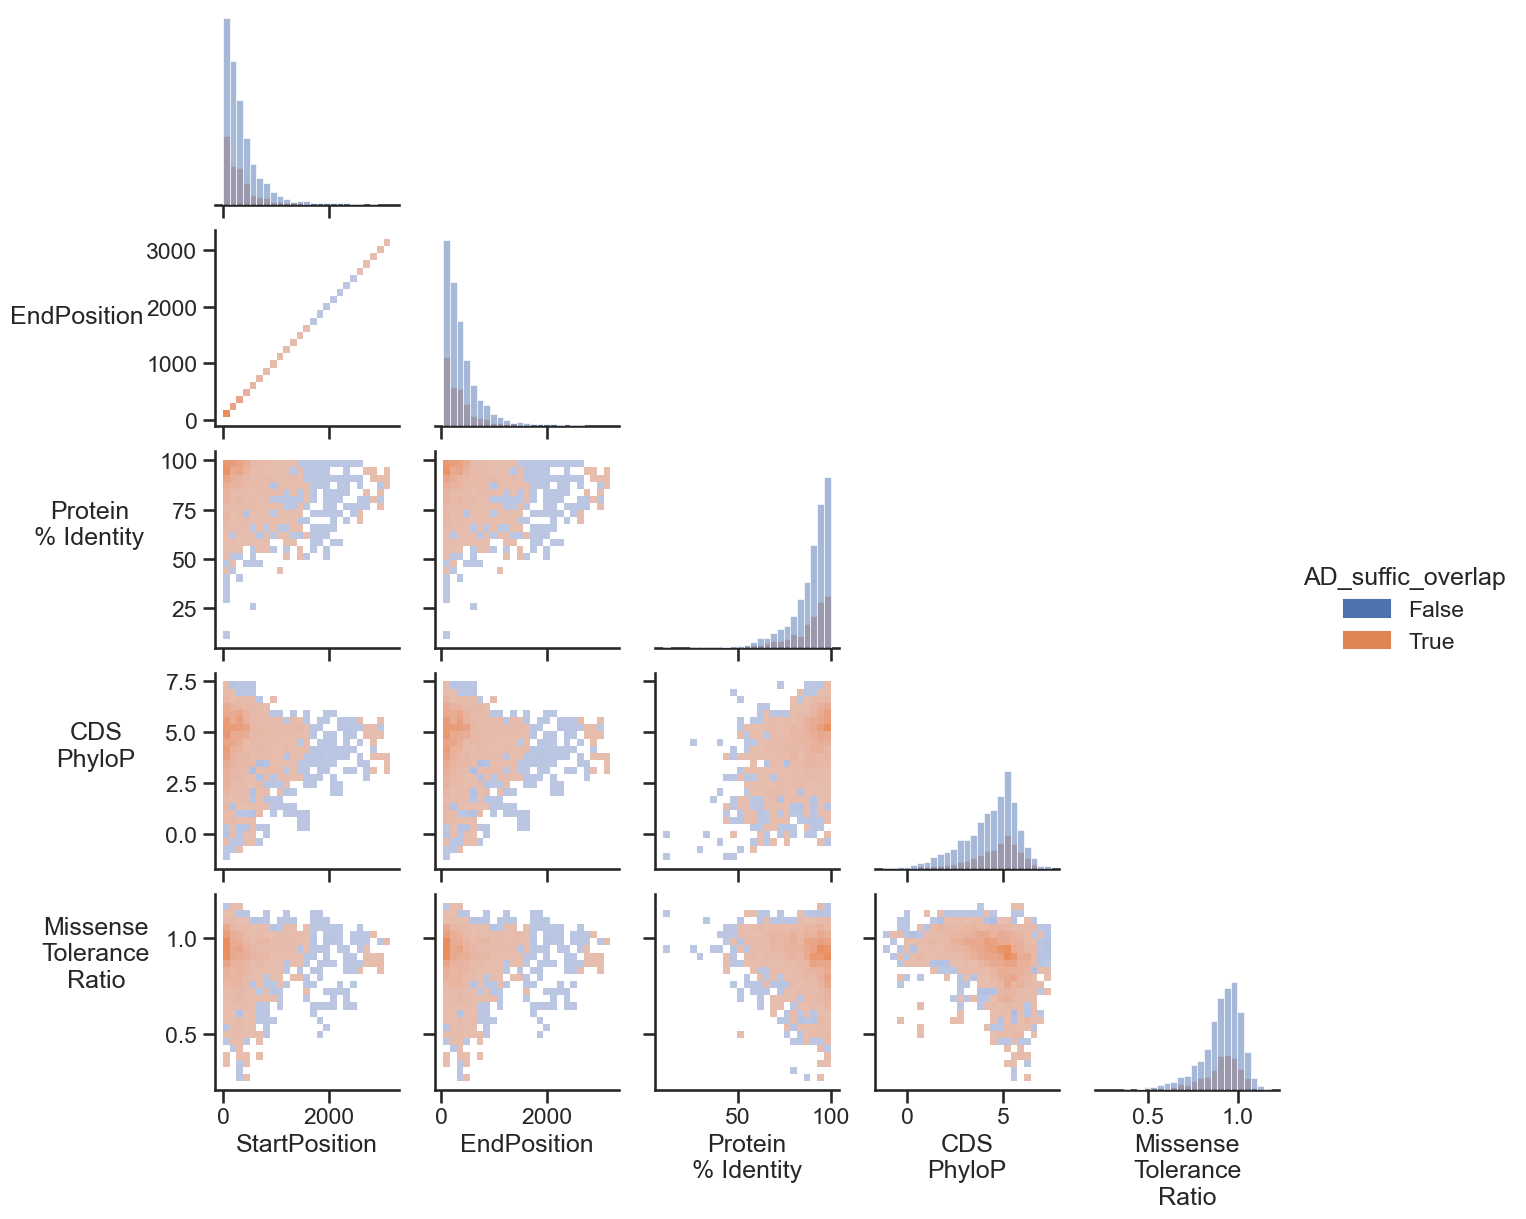

In [91]:
sns.set_context('talk')
pairplot_df = input_data.drop(columns = "percent_disorder")
pairplot_df = pairplot_df.rename(columns = {
                                            "avg_percent_identity" : "Protein\n% Identity",
                                            "average_PhyloP" : "CDS\nPhyloP",
                                           "average_MTR" : "Missense\nTolerance\nRatio"})

g = sns.pairplot(pairplot_df, kind = "hist", diag_kws={"bins" : 25, "common_norm" : False}, plot_kws={"bins" : 25}, hue = "AD_suffic_overlap", corner = True)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = "center", labelpad = 50)

plt.show()

In [92]:
input_data.to_csv("../data/classifier_input.csv")